In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
import os

In [2]:
# cwd = os.getcwd()
# cwd

In [3]:
# raw_csv_data = pd.read_csv(cwd + '\TG.csv')
raw_csv_data = pd.read_csv('KA.csv')
df=raw_csv_data.copy()

In [4]:
para = 'Confirmed'

In [5]:
df.Date.describe()

count           115
unique          115
top       26-Jun-20
freq              1
Name: Date, dtype: object

In [6]:
df

,Date,Confirmed,Recovered,Deceased
0,14-Mar-20,6,0,1
1,15-Mar-20,0,0,0
2,16-Mar-20,1,0,0
3,17-Mar-20,2,0,0
4,18-Mar-20,5,0,0
...,...,...,...,...
110,02-Jul-20,1502,271,19
111,03-Jul-20,1694,471,21
112,04-Jul-20,1839,439,42
113,05-Jul-20,1925,603,37


In [7]:
df.Date = pd.to_datetime(df.Date)

In [8]:
df.head()

,Date,Confirmed,Recovered,Deceased
0,2020-03-14,6,0,1
1,2020-03-15,0,0,0
2,2020-03-16,1,0,0
3,2020-03-17,2,0,0
4,2020-03-18,5,0,0


In [9]:
df

,Date,Confirmed,Recovered,Deceased
0,2020-03-14,6,0,1
1,2020-03-15,0,0,0
2,2020-03-16,1,0,0
3,2020-03-17,2,0,0
4,2020-03-18,5,0,0
...,...,...,...,...
110,2020-07-02,1502,271,19
111,2020-07-03,1694,471,21
112,2020-07-04,1839,439,42
113,2020-07-05,1925,603,37


In [10]:
df.set_index('Date', inplace=True)
df.index.freq = 'D'

In [11]:
df

,Confirmed,Recovered,Deceased
Date,,,
2020-03-14,6,0,1
2020-03-15,0,0,0
2020-03-16,1,0,0
2020-03-17,2,0,0
2020-03-18,5,0,0
...,...,...,...
2020-07-02,1502,271,19
2020-07-03,1694,471,21
2020-07-04,1839,439,42


In [12]:
# df.Date.describe()

In [13]:
df

,Confirmed,Recovered,Deceased
Date,,,
2020-03-14,6,0,1
2020-03-15,0,0,0
2020-03-16,1,0,0
2020-03-17,2,0,0
2020-03-18,5,0,0
...,...,...,...
2020-07-02,1502,271,19
2020-07-03,1694,471,21
2020-07-04,1839,439,42


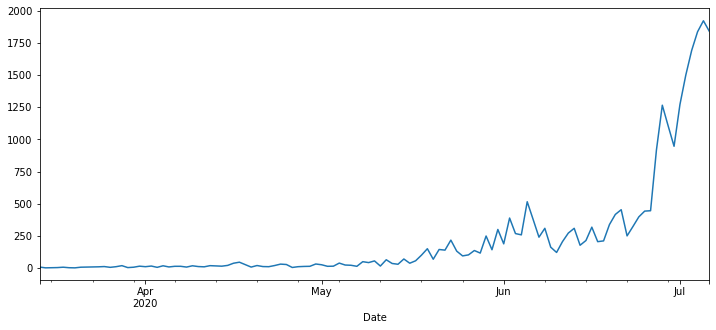

In [14]:
df[para].plot(figsize=(12,5));

In [15]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [16]:
adf_test(df[para])

Augmented Dickey-Fuller Test: 
ADF test statistic        1.839840
p-value                   0.998425
# lags used              11.000000
# observations          103.000000
critical value (1%)      -3.495493
critical value (5%)      -2.890037
critical value (10%)     -2.581971
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


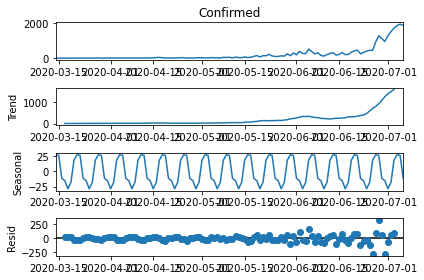

In [17]:
result = seasonal_decompose(df[para])
result.plot();

In [18]:
from statsmodels.tsa.statespace.tools import diff
df['d1'] = diff(df[para],k_diff=2)

In [19]:
adf_test(df['d1'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -5.831626e+00
p-value                 3.962755e-07
# lags used             7.000000e+00
# observations          1.050000e+02
critical value (1%)    -3.494220e+00
critical value (5%)    -2.889485e+00
critical value (10%)   -2.581676e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [20]:
# stepwise_fit = auto_arima(df[para], start_p=0, start_q=0,
#                           max_p=4, max_q=4,
#                           seasonal=False,
#                           d=None, trace=True,
#                           error_action='ignore',   # we don't want to know if an order does not work
#                           suppress_warnings=True,  # we don't want convergence warnings
#                           stepwise=True)           # set to stepwise

# stepwise_fit.summary()

stepwise_fit = auto_arima(df[para], start_p=0, start_q=0,
                          max_p=4, max_q=4,
                          seasonal=True,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True,           # set to stepwise
                         frequency=8)

stepwise_fit.summary()

Performing stepwise search to minimize aic
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1428.386, BIC=1433.841, Time=0.017 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=1412.073, BIC=1420.255, Time=0.056 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=1356.114, BIC=1364.296, Time=0.044 seconds
Near non-invertible roots for order (0, 2, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=1426.389, BIC=1429.116, Time=0.006 seconds
Fit ARIMA(2,2,0)x(0,0,0,0) [intercept=True]; AIC=1388.525, BIC=1399.435, Time=0.087 seconds
Fit ARIMA(3,2,0)x(0,0,0,0) [intercept=True]; AIC=1370.911, BIC=1384.548, Time=0.104 seconds
Fit ARIMA(4,2,0)x(0,0,0,0) [intercept=True]; AIC=1369.042, BIC=1385.406, Time=0.100 seconds
Fit ARIMA(4,2,1)x(0,0,0,0) [intercept=True]; AIC=1352.733, BIC=1371.825, Time=0.218 seconds
Fit ARIMA(3,2,1)x(0,0,0,0) [intercept=True]; AIC=1350.754, BIC

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  115
Model:               SARIMAX(1, 2, 3)   Log Likelihood                -668.455
Date:                Tue, 14 Jul 2020   AIC                           1348.909
Time:                        05:10:09   BIC                           1365.274
Sample:                             0   HQIC                          1355.550
                                - 115                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6198      1.236      0.501      0.616      -1.803       3.043
ar.L1          0.4092      0.114      3.603      0.000       0.187       0.632
ma.L1         -1.5474      0.638     -2.427      0.015      -2.797      -0.298
ma.L2          0.3246      0.489      0.664      0.507      -0.634       1.283
ma.L3          0.3541      0.231      1.533      0.125      -0.099       0.807
sigma2      7509.4212   4909.358      1.530      0.126   -2112.744    1.71e+04
===================================================================================
Ljung-Box (Q):                       44.37   Jarque-Bera (JB):                78.78
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):             220.70   Skew:                             0.77
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
train = df.iloc[:90]
test = df.iloc[90:]

In [22]:
# from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [23]:
# model = ARIMA(train[para],order=(1, 2, 3))
model = SARIMAX(train[para],order=(1, 2, 3),seasonal_order=(1,2,3,8))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                         Confirmed   No. Observations:                   90
Model:             SARIMAX(1, 2, 3)x(1, 2, 3, 8)   Log Likelihood                -412.313
Date:                           Tue, 14 Jul 2020   AIC                            842.625
Time:                                   05:10:14   BIC                            863.115
Sample:                               03-14-2020   HQIC                           850.783
                                    - 06-11-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9943     11.146     -0.089      0.929     -22.840      20.852
ma.L1         -0.4868     87.226     -0.006      0.996    -171.447     170.474
ma.L2         -0.9885     43.168     -0.023      0.982     -85.597      83.620
ma.L3          0.4753     39.846      0.012      0.990     -77.622      78.572
ar.S.L8        0.6088      2.919      0.209      0.835      -5.112       6.330
ma.S.L8       -2.3861     87.313     -0.027      0.978    -173.516     168.744
ma.S.L16       2.2990    124.363      0.018      0.985    -241.447     246.045
ma.S.L24      -0.9118     80.921     -0.011      0.991    -159.514     157.691
sigma2      3081.7684      0.077   4.02e+04      0.000    3081.618    3081.919
===================================================================================
Ljung-Box (Q):                       21.74   Jarque-Bera (JB):                59.05
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             191.75   Skew:                             0.77
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.72e+22. Standard errors may be unstable.
"""

In [24]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
# predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(2,2,1) Predictions')
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMAX(1,2,3,8) Predictions')

# df['forecast'] = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(2,2,1) Predictions')

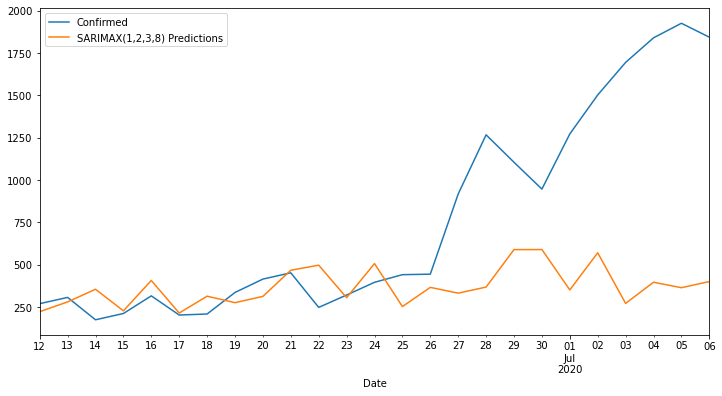

In [25]:
# Obtain predicted values
ax = test[para].plot(legend=True,figsize=(12,6))
predictions.plot(legend=True)
# df['forecast'].plot(legend=True)
ax.autoscale(axis='x',tight=True)

In [26]:
# # from statsmodels.tools.eval_measures import rmse
# from statsmodels.tools.eval_measures import mse

# error = mse(test[para], predictions)
# # print(f'ARIMA(2,2,1) RMSE Error: {error:11.10}')
# # print(f'ARIMA(2,2,1) MSE Error: {error:11.10}')
# print(f'SARIMAX(2,2,1,3) MSE Error: {error:11.10}')

In [27]:
from sklearn.metrics import mean_absolute_error
MAE = mean_absolute_error(test[para], predictions)
MAE

454.61905428542065

In [28]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# per_MAPE = (MAPE/sum(test[para]))*100
per_MAPE = mean_absolute_percentage_error(test[para], predictions)
print(per_MAPE,'%')

2.3836989004059386 %


In [29]:
type(predictions)

pandas.core.series.Series

In [30]:
df['forecast'] = predictions
df

,Confirmed,Recovered,Deceased,d1,forecast
Date,,,,,
2020-03-14,6,0,1,NaN,NaN
2020-03-15,0,0,0,NaN,NaN
2020-03-16,1,0,0,7.0,NaN
2020-03-17,2,0,0,0.0,NaN
2020-03-18,5,0,0,2.0,NaN
...,...,...,...,...,...
2020-07-02,1502,271,19,-95.0,571.152159
2020-07-03,1694,471,21,-38.0,272.760450
2020-07-04,1839,439,42,-47.0,397.364897


In [31]:
dictt = {f'{para}':test[para],f'Predicted_{para}':predictions}
dictt

{'Confirmed': Date
 2020-06-12     271
 2020-06-13     308
 2020-06-14     176
 2020-06-15     213
 2020-06-16     317
 2020-06-17     204
 2020-06-18     210
 2020-06-19     337
 2020-06-20     416
 2020-06-21     453
 2020-06-22     249
 2020-06-23     322
 2020-06-24     397
 2020-06-25     442
 2020-06-26     445
 2020-06-27     918
 2020-06-28    1267
 2020-06-29    1105
 2020-06-30     947
 2020-07-01    1272
 2020-07-02    1502
 2020-07-03    1694
 2020-07-04    1839
 2020-07-05    1925
 2020-07-06    1843
 Freq: D, Name: Confirmed, dtype: int64,
 'Predicted_Confirmed': 2020-06-12    223.871454
 2020-06-13    281.319221
 2020-06-14    355.996197
 2020-06-15    228.717272
 2020-06-16    407.783614
 2020-06-17    215.748763
 2020-06-18    315.136916
 2020-06-19    276.869091
 2020-06-20    314.052275
 2020-06-21    468.076719
 2020-06-22    498.035694
 2020-06-23    306.285307
 2020-06-24    507.352019
 2020-06-25    253.984266
 2020-06-26    367.112104
 2020-06-27    332.966569
 

In [32]:
predicted_df = pd.DataFrame(dictt)
predicted_df

,Confirmed,Predicted_Confirmed
Date,,
2020-06-12,271,223.871454
2020-06-13,308,281.319221
2020-06-14,176,355.996197
2020-06-15,213,228.717272
2020-06-16,317,407.783614
2020-06-17,204,215.748763
2020-06-18,210,315.136916
2020-06-19,337,276.869091
2020-06-20,416,314.052275


In [33]:
predicted_df.to_csv('Predicted_KA.csv')
# predicted_csv = pd.read_csv('Predicted_KA.csv')

# predicted_csv.Date = pd.to_datetime(predicted_csv.Date)
# predicted_csv.set_index('Date', inplace=True)
# predicted_csv.index.freq = 'D'
# # print(predicted_csv)
# # predicted_csv = pd.concat([predicted_csv,predicted_df],axis=1,ignore_index=True)
# predicted_csv = pd.merge(predicted_csv, predicted_df, left_index=True, right_index=True, how='outer')
# # predicted_csv = predicted_csv.join(predicted_df, how='outer')
# print(predicted_csv)
# predicted_csv.to_csv('Predicted_KA.csv')

In [34]:
from pandas.tseries.offsets import DateOffset
import datetime
future_dates=[datetime.datetime(2020, 7, 7)+ DateOffset(n=x)for x in range(0,25)]

In [35]:
future_datest_df=pd.DataFrame(index=future_dates,columns=df.columns)

In [36]:
future_datest_df.tail()

,Confirmed,Recovered,Deceased,d1,forecast
2020-07-27,NaN,NaN,NaN,NaN,NaN
2020-07-28,NaN,NaN,NaN,NaN,NaN
2020-07-29,NaN,NaN,NaN,NaN,NaN
2020-07-30,NaN,NaN,NaN,NaN,NaN
2020-07-31,NaN,NaN,NaN,NaN,NaN


In [37]:
future_df=pd.concat([df,future_datest_df])
future_df = future_df.drop("d1", axis=1)
future_df

,Confirmed,Recovered,Deceased,forecast
2020-03-14,6,0,1,NaN
2020-03-15,0,0,0,NaN
2020-03-16,1,0,0,NaN
2020-03-17,2,0,0,NaN
2020-03-18,5,0,0,NaN
...,...,...,...,...
2020-07-27,NaN,NaN,NaN,NaN
2020-07-28,NaN,NaN,NaN,NaN
2020-07-29,NaN,NaN,NaN,NaN
2020-07-30,NaN,NaN,NaN,NaN


In [38]:
future_df[[para, 'forecast']]

,Confirmed,forecast
2020-03-14,6,NaN
2020-03-15,0,NaN
2020-03-16,1,NaN
2020-03-17,2,NaN
2020-03-18,5,NaN
...,...,...
2020-07-27,NaN,NaN
2020-07-28,NaN,NaN
2020-07-29,NaN,NaN
2020-07-30,NaN,NaN


In [39]:
# future_df['forecast'] = results.predict(start = 115, end = 139, dynamic= True)
future_pred = results.predict(start=115, end=139, dynamic=False, typ='levels')

In [40]:
future_df['forecast'] = future_pred

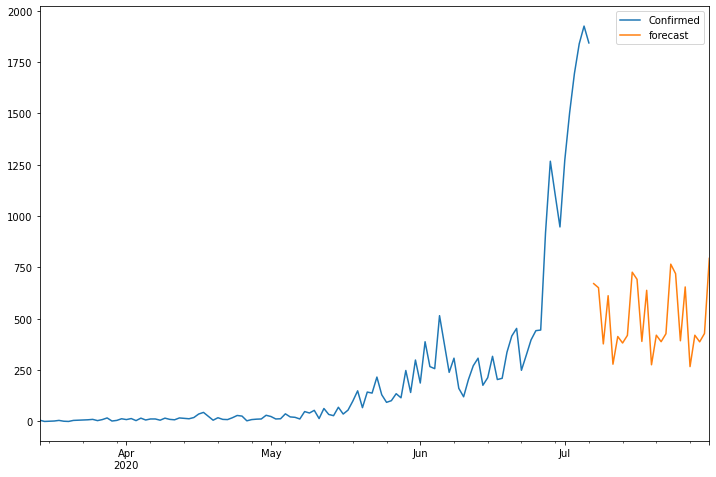

In [41]:
future_df[[para, 'forecast']].plot(figsize=(12, 8))

In [42]:
dicttt = {f'Future_Predicted_{para}':future_pred}
dicttt

{'Future_Predicted_Confirmed': 2020-07-07    671.080971
 2020-07-08    651.048361
 2020-07-09    377.514099
 2020-07-10    612.181703
 2020-07-11    278.708063
 2020-07-12    413.414843
 2020-07-13    381.917772
 2020-07-14    419.054784
 2020-07-15    726.654030
 2020-07-16    691.837438
 2020-07-17    389.638162
 2020-07-18    638.421843
 2020-07-19    275.932137
 2020-07-20    419.908270
 2020-07-21    388.312710
 2020-07-22    426.954247
 2020-07-23    765.735801
 2020-07-24    719.553093
 2020-07-25    392.792621
 2020-07-26    654.799935
 2020-07-27    267.000151
 2020-07-28    419.742398
 2020-07-29    387.589809
 2020-07-30    428.050626
 2020-07-31    793.967069
 Freq: D, dtype: float64}

In [43]:
future_predicted_df = pd.DataFrame(dicttt)
future_predicted_df

,Future_Predicted_Confirmed
2020-07-07,671.080971
2020-07-08,651.048361
2020-07-09,377.514099
2020-07-10,612.181703
2020-07-11,278.708063
2020-07-12,413.414843
2020-07-13,381.917772
2020-07-14,419.054784
2020-07-15,726.654030
2020-07-16,691.837438


In [44]:
future_predicted_df.index.names = ['Date']
future_predicted_df.index.freq = 'D'
future_predicted_df.to_csv('Future_Predicted_KA.csv')

# future_predicted_csv = pd.read_csv('Future_Predicted_KA.csv')

# future_predicted_csv.Date = pd.to_datetime(future_predicted_csv.Date)
# future_predicted_csv.set_index('Date', inplace=True)
# future_predicted_csv.index.freq = 'D'
# # print(future_predicted_csv)
# # future_predicted_csv = pd.concat([future_predicted_csv,future_predicted_df],axis=1,ignore_index=True)
# future_predicted_csv = pd.merge(future_predicted_csv, future_predicted_df, left_index=True, right_index=True, how='outer')
# # predicted_csv = predicted_csv.join(predicted_df, how='outer')
# print(future_predicted_csv)
# future_predicted_csv.to_csv('Future_Predicted_KA.csv')